In [43]:
import os, sys, csv, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
# change settings so that pandas will display 100 rows of data
pd.set_option('display.max_rows', 100)

In [45]:
grid_name = 'CISO'

grid_data_folder = 'grid-emissions'
weather_data_folder = 'weather-station-result'

In [46]:
grid_emissions_file_2019 = os.path.join(grid_data_folder, grid_name + '-' + '2019' + '.csv')
grid_emissions_file_2020 = os.path.join(grid_data_folder, grid_name + '-' + '2020' + '.csv')
grid_emissions_file_2021 = os.path.join(grid_data_folder, grid_name + '-' + '2021' + '.csv')

SF_weather_file_2019 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2019' + '.csv')
SF_weather_file_2020 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2020' + '.csv')
SF_weather_file_2021 = os.path.join(weather_data_folder, 'KSFO' + '-' + '2021' + '.csv')

LA_weather_file_2019 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2019' + '.csv')
LA_weather_file_2020 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2020' + '.csv')
LA_weather_file_2021 = os.path.join(weather_data_folder, 'KLAX' + '-' + '2021' + '.csv')

In [47]:
df_SF_weather_2019 = pd.read_csv(SF_weather_file_2019, usecols=['date_time', 'dry_bulb'])
df_SF_weather_2020 = pd.read_csv(SF_weather_file_2020, usecols=['date_time', 'dry_bulb'])
df_SF_weather_2021 = pd.read_csv(SF_weather_file_2021, usecols=['date_time', 'dry_bulb'])

df_LA_weather_2019 = pd.read_csv(LA_weather_file_2019, usecols=['date_time', 'dry_bulb'])
df_LA_weather_2020 = pd.read_csv(LA_weather_file_2020, usecols=['date_time', 'dry_bulb'])
df_LA_weather_2021 = pd.read_csv(LA_weather_file_2021, usecols=['date_time', 'dry_bulb'])

df_grid_emissions_2019 = pd.read_csv(grid_emissions_file_2019, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])
df_grid_emissions_2020 = pd.read_csv(grid_emissions_file_2020, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])
df_grid_emissions_2021 = pd.read_csv(grid_emissions_file_2021, usecols=['datetime_local', 'consumed_co2e_rate_kg_per_mwh_for_electricity'])

In [48]:
# remove leap day data from df_grid_emissions_2020 (since weather file removed it)
df_grid_emissions_2020 = df_grid_emissions_2020[~df_grid_emissions_2020['datetime_local'].str.contains('02-29')]

In [49]:
df_grid_emissions_2020.shape

(8760, 2)

In [50]:
df_SF_weather_3yrs = pd.concat([df_SF_weather_2019, df_SF_weather_2020, df_SF_weather_2021]).rename(columns={'dry_bulb': 'SF_temp'})
df_LA_weather_3yrs = pd.concat([df_LA_weather_2019, df_LA_weather_2020, df_LA_weather_2021]).rename(columns={'dry_bulb': 'LA_temp'})

df_CA_weather_3yrs = pd.merge(df_SF_weather_3yrs, df_LA_weather_3yrs, on='date_time')

In [51]:
# find the rows with null values
df_CA_weather_3yrs[df_CA_weather_3yrs.isnull().any(axis=1)]

,date_time,SF_temp,LA_temp
22106,2021-07-11-02:00,NaN,18.992308
22107,2021-07-11-03:00,NaN,18.023077
22108,2021-07-11-04:00,NaN,18.176923
22109,2021-07-11-05:00,NaN,18.800000
22110,2021-07-11-06:00,NaN,20.430769
22111,2021-07-11-07:00,NaN,21.130769
22112,2021-07-11-08:00,NaN,22.446154
22113,2021-07-11-09:00,NaN,22.792308
22114,2021-07-11-10:00,NaN,23.300000
22115,2021-07-11-11:00,NaN,23.530769


In [52]:
df_CA_weather_3yrs.isnull().sum()

date_time     0
SF_temp      12
LA_temp       0
dtype: int64

In [53]:
# interpolate the null values
df_CA_weather_3yrs[['SF_temp', 'LA_temp']] = df_CA_weather_3yrs[['SF_temp', 'LA_temp']].interpolate()

In [54]:
df_CA_weather_3yrs[22100:22120]

,date_time,SF_temp,LA_temp
22100,2021-07-10-20:00,15.969231,18.992308
22101,2021-07-10-21:00,14.723077,18.992308
22102,2021-07-10-22:00,14.875000,19.030769
22103,2021-07-10-23:00,14.936842,18.990909
22104,2021-07-11-00:00,14.998684,18.992308
22105,2021-07-11-01:00,15.060526,18.992308
22106,2021-07-11-02:00,15.122368,18.992308
22107,2021-07-11-03:00,15.184211,18.023077
22108,2021-07-11-04:00,15.246053,18.176923
22109,2021-07-11-05:00,15.307895,18.800000


In [55]:
# convert date_time column to datetime type
df_CA_weather_3yrs['date_time'] = pd.to_datetime(df_CA_weather_3yrs['date_time'])
df_CA_weather_3yrs.reset_index(drop=True)
df_CA_weather_3yrs

,date_time,SF_temp,LA_temp
0,2019-01-01 00:00:00,10.661538,10.757143
1,2019-01-01 01:00:00,10.538462,10.238462
2,2019-01-01 02:00:00,9.876923,9.723077
3,2019-01-01 03:00:00,9.223077,7.930769
4,2019-01-01 04:00:00,8.561538,7.446154
...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923
26276,2021-12-31 20:00:00,8.992308,12.015385
26277,2021-12-31 21:00:00,8.253846,11.976923
26278,2021-12-31 22:00:00,8.684615,12.092308


In [56]:
df_CA_weather_3yrs.dtypes

date_time    datetime64[ns]
SF_temp             float64
LA_temp             float64
dtype: object

In [57]:
df_grid_emissions_3yrs = pd.concat([df_grid_emissions_2019, df_grid_emissions_2020, df_grid_emissions_2021]).rename(columns={'consumed_co2e_rate_kg_per_mwh_for_electricity': 'grid_emissions'})

In [58]:
# re-index df_grid_emissions_3yrs
df_grid_emissions_3yrs = df_grid_emissions_3yrs.reset_index(drop=True)
df_grid_emissions_3yrs

,datetime_local,grid_emissions
0,2019-01-01 00:00:00-08:00,308.79
1,2019-01-01 01:00:00-08:00,309.58
2,2019-01-01 02:00:00-08:00,314.50
3,2019-01-01 03:00:00-08:00,316.74
4,2019-01-01 04:00:00-08:00,316.34
...,...,...
26275,2021-12-31 19:00:00-08:00,273.29
26276,2021-12-31 20:00:00-08:00,277.30
26277,2021-12-31 21:00:00-08:00,277.92
26278,2021-12-31 22:00:00-08:00,266.93


In [59]:
df_combined_3yrs = pd.merge(df_CA_weather_3yrs, df_grid_emissions_3yrs, left_index=True, right_index=True).drop(columns=['datetime_local'])
df_combined_3yrs

,date_time,SF_temp,LA_temp,grid_emissions
0,2019-01-01 00:00:00,10.661538,10.757143,308.79
1,2019-01-01 01:00:00,10.538462,10.238462,309.58
2,2019-01-01 02:00:00,9.876923,9.723077,314.50
3,2019-01-01 03:00:00,9.223077,7.930769,316.74
4,2019-01-01 04:00:00,8.561538,7.446154,316.34
...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,273.29
26276,2021-12-31 20:00:00,8.992308,12.015385,277.30
26277,2021-12-31 21:00:00,8.253846,11.976923,277.92
26278,2021-12-31 22:00:00,8.684615,12.092308,266.93


In [60]:
#create columns for month, day of week, and hour of day
df_combined_3yrs['month'] = df_combined_3yrs['date_time'].dt.month
df_combined_3yrs['day_of_week'] = df_combined_3yrs['date_time'].dt.dayofweek
df_combined_3yrs['hour_of_day'] = df_combined_3yrs['date_time'].dt.hour

In [61]:
df_combined_3yrs_withdummies = pd.get_dummies(df_combined_3yrs, columns=['month', 'day_of_week', 'hour_of_day'])

In [62]:
df_combined_3yrs_withdummies

,date_time,SF_temp,LA_temp,grid_emissions,month_1,month_2,month_3,month_4,month_5,month_6,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,2019-01-01 00:00:00,10.661538,10.757143,308.79,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 01:00:00,10.538462,10.238462,309.58,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2019-01-01 02:00:00,9.876923,9.723077,314.50,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 03:00:00,9.223077,7.930769,316.74,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2019-01-01 04:00:00,8.561538,7.446154,316.34,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2021-12-31 19:00:00,9.030769,12.476923,273.29,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
26276,2021-12-31 20:00:00,8.992308,12.015385,277.30,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
26277,2021-12-31 21:00:00,8.253846,11.976923,277.92,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26278,2021-12-31 22:00:00,8.684615,12.092308,266.93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [63]:
# create a new dataframe for data with year 2019 or 2020
df_combined_2019_2020 = df_combined_3yrs_withdummies[df_combined_3yrs_withdummies['date_time'].dt.year.isin([2019, 2020])].reset_index(drop=True)

# create a new dataframe for data with year 2021
df_combined_2021 = df_combined_3yrs_withdummies[df_combined_3yrs_withdummies['date_time'].dt.year.isin([2021])].reset_index(drop=True)

In [64]:
df_combined_2019_2020.shape, df_combined_2021.shape

((17520, 47), (8760, 47))

In [65]:
X_train = df_combined_2019_2020.drop(columns=['date_time', 'grid_emissions'])
y_train = df_combined_2019_2020['grid_emissions']

X_test = df_combined_2021.drop(columns=['date_time', 'grid_emissions'])
y_test = df_combined_2021['grid_emissions']

In [66]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [67]:
# use standard scalar on df_CA_weather_grid to scale columns 'SF_dry_bulb', 'LA_dry_bulb'
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['SF_temp', 'LA_temp']] = scaler.fit_transform(X_train_scaled[['SF_temp', 'LA_temp']])
X_test_scaled[['SF_temp', 'LA_temp']] = scaler.transform(X_test_scaled[['SF_temp', 'LA_temp']])

In [68]:
# get scaler mean and std
scaler_mean = scaler.mean_
scaler_std = scaler.scale_
scaler_mean, scaler_std

(array([14.79381011, 17.58368283]), array([4.3586109 , 4.08224107]))

In [69]:
X_train_scaled

,SF_temp,LA_temp,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,-0.948071,-1.672253,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.976308,-1.799311,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.128086,-1.925561,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-1.278098,-2.364611,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1.429876,-2.483324,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,-0.745113,-0.444475,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
17516,-0.905714,-0.632908,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
17517,-1.260450,-0.738431,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17518,-1.383989,-0.860912,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [70]:
# Linear Regression
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# predict
y_pred_train_linreg = linreg.predict(X_train_scaled)
y_pred_test_linreg = linreg.predict(X_test_scaled)

# MSE and RMSE
linreg_mse_train = mean_squared_error(y_train, y_pred_train_linreg)
linreg_mse_test = mean_squared_error(y_test, y_pred_test_linreg)
linreg_rmse_train = np.sqrt(linreg_mse_train)
linreg_rmse_test = np.sqrt(linreg_mse_test)

# r2 score
linreg_r2_train = r2_score(y_train, y_pred_train_linreg)
linreg_r2_test = r2_score(y_test, y_pred_test_linreg)

In [71]:
y_pred_train_linreg

array([309.53125   , 309.50097656, 309.83789062, ..., 323.05566406,
       322.04980469, 322.60839844])

In [72]:
# Make a table of results for train and test errors
d = {'train': [linreg_mse_train, linreg_rmse_train, linreg_r2_train], 'test': [linreg_mse_test, linreg_rmse_test, linreg_r2_test]}
df_linreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Simple Multi-Linear Regression:')
df_linreg_results

Simple Multi-Linear Regression:


,train,test
MSE,937.207438,1447.873471
RMSE,30.613844,38.050933
R2,0.790090,0.593726


In [73]:
# polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.fit_transform(X_test_scaled)

polyreg = LinearRegression(fit_intercept=True)
polyreg.fit(X_train_poly, y_train)

# predict
y_pred_poly_train = polyreg.predict(X_train_poly)
y_pred_poly_test = polyreg.predict(X_test_poly)

# MSE and RMSE
polyreg_mse_train = mean_squared_error(y_train, y_pred_poly_train)
polyreg_rmse_train = np.sqrt(polyreg_mse_train)
polyreg_mse_test = mean_squared_error(y_test, y_pred_poly_test)
polyreg_rmse_test = np.sqrt(polyreg_mse_test)

# r2 score
polyreg_r2_train = r2_score(y_train, y_pred_poly_train)
polyreg_r2_test = r2_score(y_test, y_pred_poly_test)

In [74]:
# Make a table of results for train and test errors
d = {'train': [polyreg_mse_train, polyreg_rmse_train, polyreg_r2_train], 'test': [polyreg_mse_test, polyreg_rmse_test, polyreg_r2_test]}
df_polyreg_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Polynomial Regression (degree=2):')
df_polyreg_results

Polynomial Regression (degree=2):


,train,test
MSE,664.362290,1402.464168
RMSE,25.775226,37.449488
R2,0.851200,0.606468


In [75]:
y_pred_poly_test, y_test

(array([300.39941406, 302.33691406, 304.36816406, ..., 299.97753906,
        299.05566406, 298.46191406]),
 0       296.51
 1       292.29
 2       283.67
 3       288.36
 4       290.71
          ...  
 8755    273.29
 8756    277.30
 8757    277.92
 8758    266.93
 8759    272.90
 Name: grid_emissions, Length: 8760, dtype: float64)

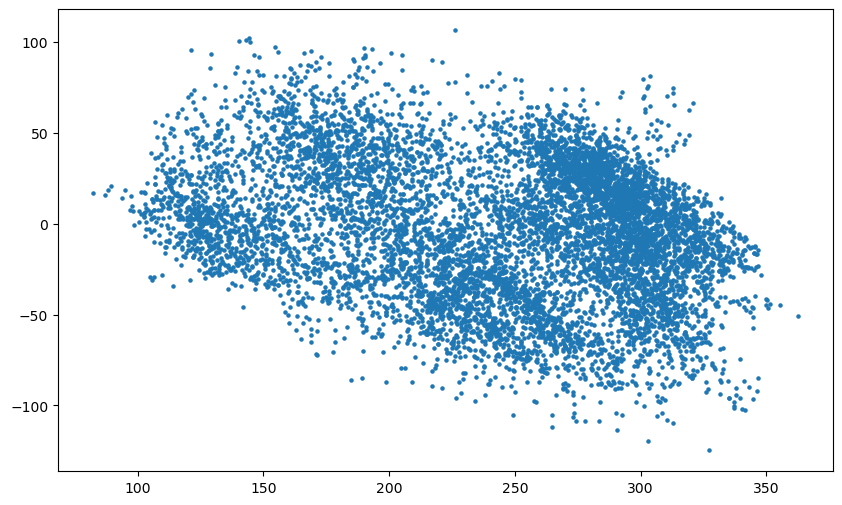

In [76]:
# create a plot with y_test and y_pred_test
errors = y_pred_poly_test - y_test

plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, s=5)

In [77]:
errors

0        3.889414
1       10.046914
2       20.698164
3       18.195664
4       18.033164
          ...    
8755    23.468789
8756    21.505664
8757    22.057539
8758    32.125664
8759    25.561914
Name: grid_emissions, Length: 8760, dtype: float64

In [78]:
plt.figure(figsize=(20,10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

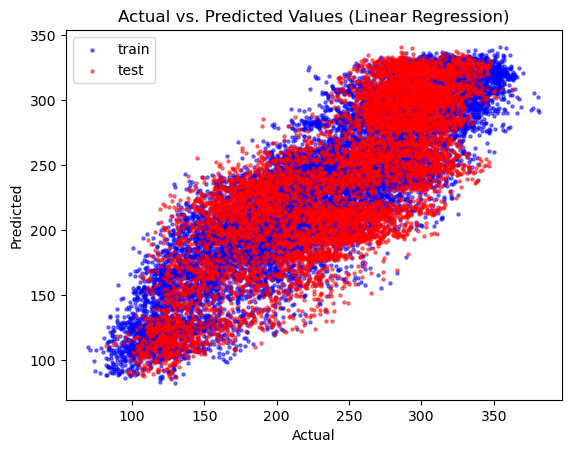

In [79]:
# plot actual vs predicted values for train and test sets
plt.scatter(y_train, y_pred_train_linreg, color='blue', label='train', s=5, alpha=.5)
plt.scatter(y_test, y_pred_test_linreg, color='red', label='test', s=5, alpha = .5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Linear Regression)')
plt.legend()


In [80]:
# Ridge Regression
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train, y_train)

# predict
y_pred_train_ridge = ridge.predict(X_train)
y_pred_test_ridge = ridge.predict(X_test)

# MSE and RMSE
ridge_mse_train = mean_squared_error(y_train, y_pred_train_ridge)
ridge_rmse_train = np.sqrt(ridge_mse_train)
ridge_mse_test = mean_squared_error(y_test, y_pred_test_ridge)
ridge_rmse_test = np.sqrt(ridge_mse_test)

# r2 score
ridge_r2_train = r2_score(y_train, y_pred_train_ridge)
ridge_r2_test = r2_score(y_test, y_pred_test_ridge)


c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [81]:
# Make a table of results for train and test errors
d = {'train': [ridge_mse_train, ridge_rmse_train, ridge_r2_train], 'test': [ridge_mse_test, ridge_rmse_test, ridge_r2_test]}
df_ridge_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Ridge Regression:')
df_ridge_results

Ridge Regression:


,train,test
MSE,972.848369,1360.115487
RMSE,31.190517,36.879744
R2,0.782107,0.618351


In [82]:
# Lasso Regression
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)

# predict
y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

# MSE and RMSE
lasso_mse_train = mean_squared_error(y_train, y_pred_train_lasso)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_mse_test = mean_squared_error(y_test, y_pred_test_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)

# r2 score
lasso_r2_train = r2_score(y_train, y_pred_train_lasso)
lasso_r2_test = r2_score(y_test, y_pred_test_lasso)


c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [83]:
# Make a table of results for train and test errors
d = {'train': [lasso_mse_train, lasso_rmse_train, lasso_r2_train], 'test': [lasso_mse_test, lasso_rmse_test, lasso_r2_test]}
df_lasso_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Lasso Regression:')
df_lasso_results

Lasso Regression:


,train,test
MSE,3397.959872,2929.137650
RMSE,58.292022,54.121508
R2,0.238944,0.178083


In [84]:
# use ridge regression on the polynomial features data
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_train_poly, y_train)

# predict
y_pred_train_ridge_poly = ridge.predict(X_train_poly)
y_pred_test_ridge_poly = ridge.predict(X_test_poly)

# MSE and RMSE
ridge_mse_train_poly = mean_squared_error(y_train, y_pred_train_ridge_poly)
ridge_rmse_train_poly = np.sqrt(ridge_mse_train_poly)
ridge_mse_test_poly = mean_squared_error(y_test, y_pred_test_ridge_poly)
ridge_rmse_test_poly = np.sqrt(ridge_mse_test_poly)

# r2 score
ridge_r2_train_poly = r2_score(y_train, y_pred_train_ridge_poly)
ridge_r2_test_poly = r2_score(y_test, y_pred_test_ridge_poly)

c:\Users\trent\.conda\envs\idep\Lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [85]:
# Make a table of results for train and test errors
d = {'train': [ridge_mse_train_poly, ridge_rmse_train_poly, ridge_r2_train_poly], 'test': [ridge_mse_test_poly, ridge_rmse_test_poly, ridge_r2_test_poly]}
df_ridge_poly_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Ridge Regression (polynomial features):')
df_ridge_poly_results

Ridge Regression (polynomial features):


,train,test
MSE,680.972883,1303.515668
RMSE,26.095457,36.104233
R2,0.847480,0.634233


In [90]:
# try decision tree regression
from sklearn.tree import DecisionTreeRegressor

# create a decision tree regressor
tree_reg = DecisionTreeRegressor(max_depth=10)

# fit the regressor to the training data
tree_reg.fit(X_train_scaled, y_train)

# predict
y_pred_train_tree = tree_reg.predict(X_train_scaled)
y_pred_test_tree = tree_reg.predict(X_test_scaled)

# MSE and RMSE
tree_mse_train = mean_squared_error(y_train, y_pred_train_tree)
tree_rmse_train = np.sqrt(tree_mse_train)
tree_mse_test = mean_squared_error(y_test, y_pred_test_tree)
tree_rmse_test = np.sqrt(tree_mse_test)

# r2 score
tree_r2_train = r2_score(y_train, y_pred_train_tree)
tree_r2_test = r2_score(y_test, y_pred_test_tree)


In [91]:
# Make a table of results for train and test errors
d = {'train': [tree_mse_train, tree_rmse_train, tree_r2_train], 'test': [tree_mse_test, tree_rmse_test, tree_r2_test]}
df_tree_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Decision Tree Regression:')
df_tree_results

Decision Tree Regression:


,train,test
MSE,1407.687655,2298.418253
RMSE,37.519164,47.941822
R2,0.684714,0.355063


In [94]:
# try random forest regression
from sklearn.ensemble import RandomForestRegressor

# create a random forest regressor
forest_reg = RandomForestRegressor(n_estimators=200, max_depth=10)

# fit the regressor to the training data
forest_reg.fit(X_train_scaled, y_train)

# predict
y_pred_train_forest = forest_reg.predict(X_train_scaled)
y_pred_test_forest = forest_reg.predict(X_test_scaled)

# MSE and RMSE
forest_mse_train = mean_squared_error(y_train, y_pred_train_forest)
forest_rmse_train = np.sqrt(forest_mse_train)
forest_mse_test = mean_squared_error(y_test, y_pred_test_forest)
forest_rmse_test = np.sqrt(forest_mse_test)

# r2 score
forest_r2_train = r2_score(y_train, y_pred_train_forest)
forest_r2_test = r2_score(y_test, y_pred_test_forest)


In [95]:
# Make a table of results for train and test errors
d = {'train': [forest_mse_train, forest_rmse_train, forest_r2_train], 'test': [forest_mse_test, forest_rmse_test, forest_r2_test]}
df_forest_results = pd.DataFrame(data=d, index=['MSE', 'RMSE', 'R2'])
print('Random Forest Regression:')
df_forest_results

Random Forest Regression:


,train,test
MSE,1234.868002,2067.853593
RMSE,35.140689,45.473658
R2,0.723421,0.419760
